In [ ]:
!pip install xgboost
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#load dataframe
b = pd.read_csv('both clean 2.csv')
''' b contains both datasets. no handling null values'''

<ipython-input-13-dc909915fa4d>:2: DtypeWarning: Columns (4,5,7,8,9,13,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  b = pd.read_csv('both clean 2.csv')


' b contains both datasets. no handling null values'

In [ ]:
columns_to_fill = ['Phone Area Code', 'Phone Number','Lead Status', 'Lead Quality', 'Lead Source','Campaign Name',
                   'Lead Created Date', 'download_date']

# Fill null values with 'None' in specified columns
b[columns_to_fill] = b[columns_to_fill].fillna('None')

In [ ]:
'''

xgboost with RE and raw datas, predicting if will become any sort of lead. Duplicate rarer events to balance data.
test size = .7

XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)


predicters:
'Property City', 'Property State', 'Property Zip', 'Mailing City', 'Mailing State', 'Mailing Zip'
'Bedroom', 'Bathroom', 'Apporx Sqft','Lot Size Sqft', 'Effective Year Built', 'House Type',
'Tax Assessed Value', 'Last Sold Price'

target:
'Lead at all'

'''

"\n\nxgboost with RE and raw datas, predicting if will become any sort of lead. Duplicate rarer events to balance data.\ntest size = .7\n\nXGBClassifier(\n    use_label_encoder=False,\n    eval_metric='mlogloss',\n    n_estimators=100,\n    max_depth=4,\n    learning_rate=0.1,\n    subsample=0.8,\n    colsample_bytree=0.8\n)\n\n\npredicters:\n'Property City', 'Property State', 'Property Zip', 'Mailing City', 'Mailing State', 'Mailing Zip'\n'Bedroom', 'Bathroom', 'Apporx Sqft','Lot Size Sqft', 'Effective Year Built', 'House Type',\n'Tax Assessed Value', 'Last Sold Price'\n\ntarget:\n'Lead at all'\n\n"

In [ ]:
b['score'].unique()

array([ 1.,  0.,  3.,  6., -1.,  5.,  2.,  4.,  7., -3., nan])

In [ ]:
#create the column 'Lead at all' based on the score
b['score'].unique()
b['Lead at all'] = b['score'].apply(lambda x: 1 if x >= -1 else 0 if x < -1 else 0)

In [ ]:
b['Lead at all'].unique()

array([1, 0])

In [ ]:
#Use one hot encoding for categorical variables.
encoded_property_city = pd.get_dummies(b['Property City'], prefix='Property_City')
encoded_property_state = pd.get_dummies(b['Property State'], prefix='Property_State')
encoded_property_zip = pd.get_dummies(b['Property Zip'].astype(str), prefix='Property_Zip')
encoded_mailing_city = pd.get_dummies(b['Mailing City'], prefix='Mailing_City')
encoded_mailing_state = pd.get_dummies(b['Mailing State'], prefix='Mailing_State')
encoded_mailing_zip = pd.get_dummies(b['Mailing Zip'].astype(str), prefix='Mailing_Zip')
encoded_house_type = pd.get_dummies(b['House Type'], prefix='House Type')
encoded_gender = pd.get_dummies(b['Gender'], prefix='Gender')


In [ ]:
# Combine all the encoded features into a single DataFrame
b_features = pd.concat([
    encoded_property_city,
    encoded_property_state,
    encoded_property_zip,
    encoded_mailing_city,
    encoded_mailing_state,
    encoded_mailing_zip,
    encoded_house_type,
    encoded_gender,
    b['Bedroom'],
    b['Bathroom'],
    b['Apporx Sqft'],
    b['Lot Size Sqft'],
    b['Effective Year Built'],
    b['Tax Assessed Value'],
    b['Last Sold Price'],
], axis=1)

In [ ]:
#create model1
X = b_features
y = b['Lead at all']

# Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)

# Identify and Separate Minority and Majority Classes
minority_class = y_train.value_counts().idxmin()
majority_class = y_train.value_counts().idxmax()

X_train_minority = X_train[y_train == minority_class]
y_train_minority = y_train[y_train == minority_class]
X_train_majority = X_train[y_train == majority_class]
y_train_majority = y_train[y_train == majority_class]

#  Duplicate Rarer Events to Balance the Dataset
n_minority = len(X_train_minority)
n_majority = len(X_train_majority)
n_duplicate = n_majority - n_minority

X_train_minority_upsampled = X_train_minority.sample(n=n_duplicate, replace=True, random_state=42)
y_train_minority_upsampled = y_train_minority.sample(n=n_duplicate, replace=True, random_state=42)

X_train_balanced = pd.concat([X_train_majority, X_train_minority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority, y_train_minority_upsampled])

#  Manually Set Hyperparameters
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

#  Train the Model
model = xgb.fit(X_train_balanced, y_train_balanced)

#  Evaluate the Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='binary')  # Use average='binary' for binary classification
precision = precision_score(y_test, y_pred, average='binary')  # Use average='binary' for binary classification
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")
print(f"Test Precision: {precision}")

F1 Score: 0.9758342922899885
Test Accuracy: 0.9987014593123917
Test Recall: 0.9780853517877739
Test Precision: 0.9735935706084959


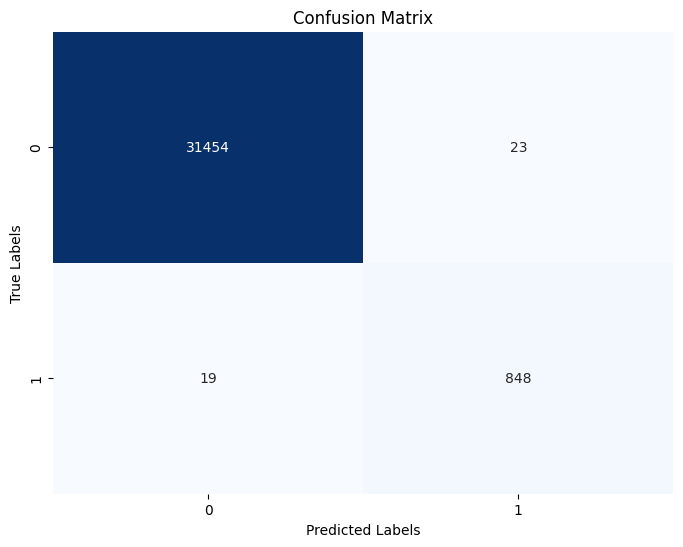

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb.classes_, yticklabels=xgb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<Figure size 1000x800 with 0 Axes>

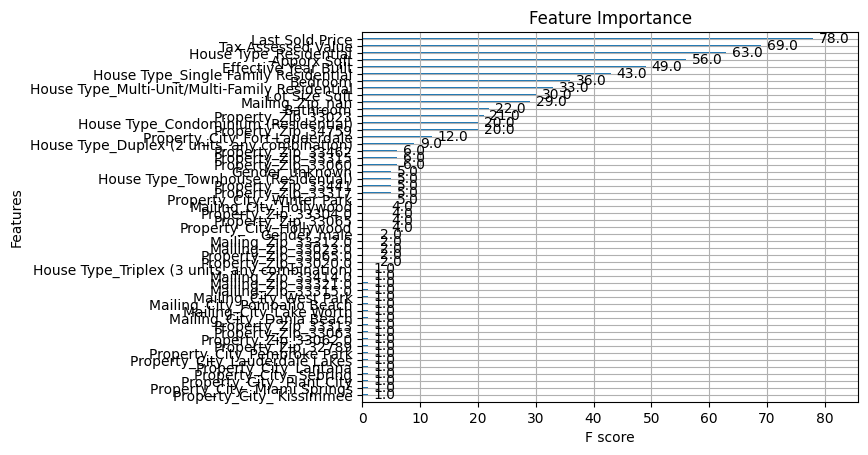

                                           Feature  Importance
51                                 Last Sold Price        78.0
50                              Tax Assessed Value        69.0
39                          House Type_Residential        63.0
47                                     Apporx Sqft        56.0
49                            Effective Year Built        49.0
40            House Type_Single Family Residential        43.0
45                                         Bedroom        36.0
38  House Type_Multi-Unit/Multi-Family Residential        33.0
48                                   Lot Size Sqft        30.0
35                                 Mailing_Zip_nan        29.0
46                                        Bathroom        22.0
12                              Property_Zip_33023        21.0
24                              Property_Zip_34759        20.0
36            House Type_Condominium (Residential)        20.0
5                    Property_City_Fort Lauderdale     

In [ ]:
  # Plot Feature Importances
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight')
plt.title('Feature Importance')
plt.show()

#  Get Feature Importances as a DataFrame
feature_importances = model.get_booster().get_score(importance_type='weight')
feature_importances_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
print(feature_importances_df)



In [ ]:
feature_importances_df.head(20)

                                           Feature  Importance
51                                 Last Sold Price        78.0
50                              Tax Assessed Value        69.0
39                          House Type_Residential        63.0
47                                     Apporx Sqft        56.0
49                            Effective Year Built        49.0
40            House Type_Single Family Residential        43.0
45                                         Bedroom        36.0
38  House Type_Multi-Unit/Multi-Family Residential        33.0
48                                   Lot Size Sqft        30.0
35                                 Mailing_Zip_nan        29.0
46                                        Bathroom        22.0
12                              Property_Zip_33023        21.0
24                              Property_Zip_34759        20.0
36            House Type_Condominium (Residential)        20.0
5                    Property_City_Fort Lauderdale     

<ipython-input-32-6dda7e2cbe21>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')


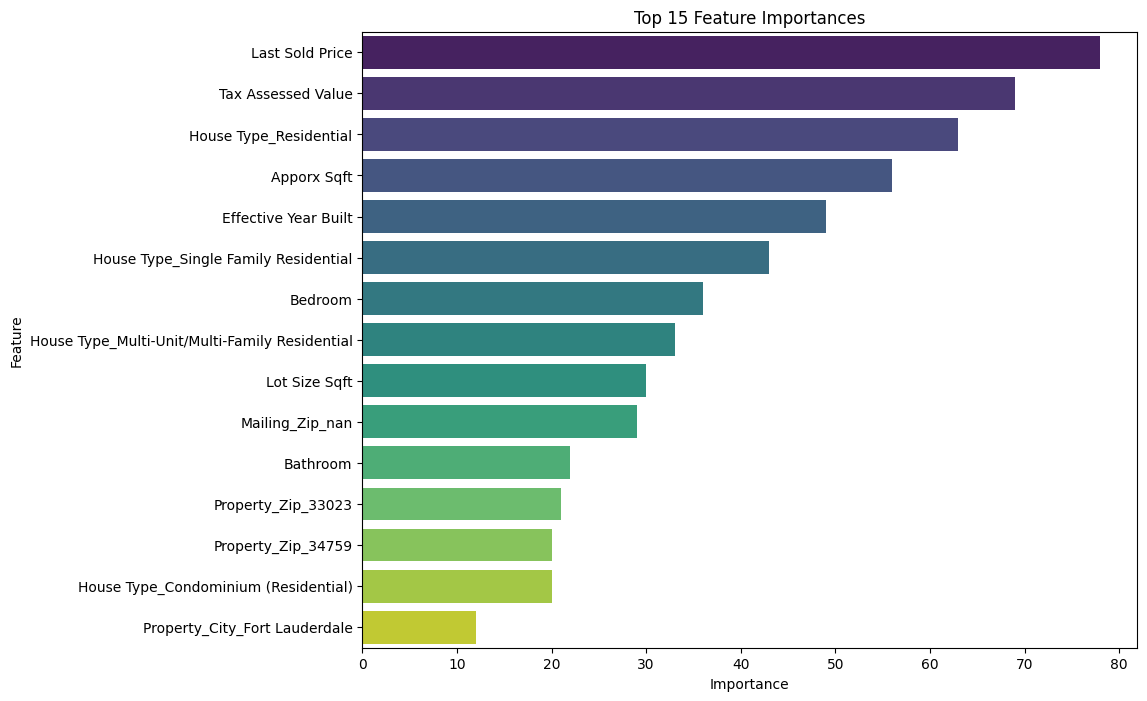

In [ ]:
# Get top 15 features
top_15_features = feature_importances_df.head(15)
print(top_15_features)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.show()

In [ ]:
'''

model2. xgboost with RE and raw, predicting if will become any sort of lead and using less features.


Predictors:
    b['Tax Assessed Value'],
    b['Last Sold Price'],
    encoded_house_type,
    b['Apporx Sqft'],
    b['Effective Year Built']


Target:
b['Lead at all']

'''

In [ ]:
#retrain with top feature importances model2
b_features2 = pd.concat([
    b['Tax Assessed Value'],
    b['Last Sold Price'],
    encoded_house_type,
    b['Apporx Sqft'],
    b['Effective Year Built']], axis=1)

In [ ]:
X2 = b_features2
y2 = b['Lead at all']

# Split Data into Training and Test Sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.7, random_state=42, stratify=y2)

# Identify and Separate Minority and Majority Classes
minority_class2 = y_train2.value_counts().idxmin()
majority_class2 = y_train2.value_counts().idxmax()

X_train_minority2 = X_train2[y_train2 == minority_class2]
y_train_minority2 = y_train2[y_train2 == minority_class2]
X_train_majority2 = X_train2[y_train2 == majority_class2]
y_train_majority2 = y_train2[y_train2 == majority_class2]

#  Duplicate Rarer Events to Balance the Dataset
n_minority2 = len(X_train_minority2)
n_majority2 = len(X_train_majority2)
n_duplicate2 = n_majority2 - n_minority2

X_train_minority_upsampled2 = X_train_minority2.sample(n=n_duplicate, replace=True, random_state=42)
y_train_minority_upsampled2 = y_train_minority2.sample(n=n_duplicate, replace=True, random_state=42)

X_train_balanced2 = pd.concat([X_train_majority2, X_train_minority2, X_train_minority_upsampled2])
y_train_balanced2 = pd.concat([y_train_majority2, y_train_minority2, y_train_minority_upsampled2])

In [ ]:
#  Manually Set Hyperparameters
xgb2 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

#  Train the Model
model2 = xgb2.fit(X_train_balanced2, y_train_balanced2)

#  Evaluate the Model
y_pred2 = model2.predict(X_test2)

accuracy2 = accuracy_score(y_test2, y_pred2)
recall2 = recall_score(y_test2, y_pred2, average='binary')  # Use average='binary' for binary classification
precision2 = precision_score(y_test2, y_pred2, average='binary')  # Use average='binary' for binary classification
f12 = f1_score(y_test2, y_pred2)
print("F1 Score:", f12)
print(f"Test Accuracy: {accuracy2}")
print(f"Test Recall: {recall2}")
print(f"Test Precision: {precision2}")

#

F1 Score: 0.9403153153153153
Test Accuracy: 0.9967227306455603
Test Recall: 0.9630911188004614
Test Precision: 0.9185918591859186


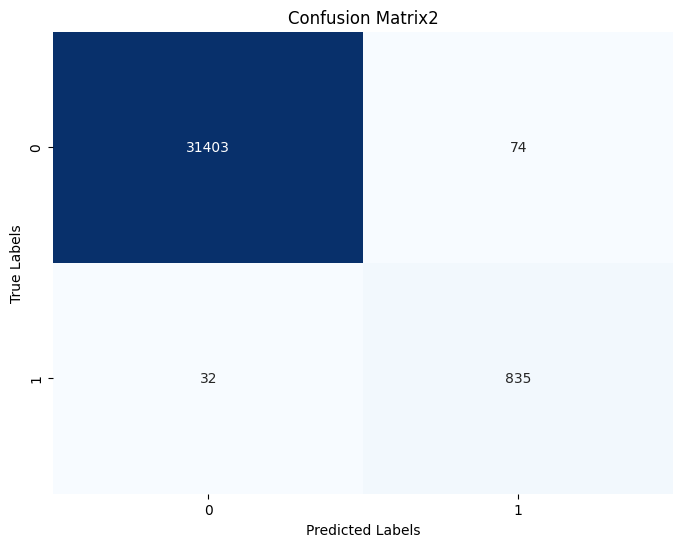

In [ ]:
#confusion matrix
cm2 = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb2.classes_, yticklabels=xgb2.classes_)
plt.title('Confusion Matrix2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
'''

model3. xgboost with RE and raw, predicting if will become any sort of lead and using less features
and adjusted hyperparameters to avoid overfitting.

'''

In [ ]:
#  Manually Set Hyperparameters to tune for overfitting
xgb3 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0
)

#  Train the Model
model3 = xgb3.fit(X_train_balanced2, y_train_balanced2)

#  Evaluate the Model
y_pred3 = model3.predict(X_test2)

accuracy3 = accuracy_score(y_test2, y_pred3)
recall3 = recall_score(y_test2, y_pred3, average='binary')  # Use average='binary' for binary classification
precision3 = precision_score(y_test2, y_pred3, average='binary')  # Use average='binary' for binary classification
f13 = f1_score(y_test2, y_pred3)
print("F1 Score:", f13)
print(f"Test Accuracy: {accuracy3}")
print(f"Test Recall: {recall3}")
print(f"Test Precision: {precision3}")

#

F1 Score: 0.914534567229178
Test Accuracy: 0.9951459312391788
Test Recall: 0.9688581314878892
Test Precision: 0.865979381443299


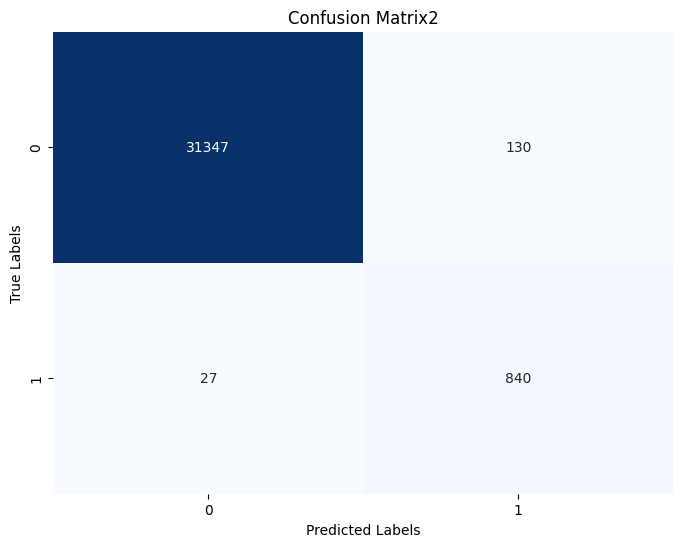

In [ ]:
#confusion matrix
cm2 = confusion_matrix(y_test2, y_pred3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb2.classes_, yticklabels=xgb2.classes_)
plt.title('Confusion Matrix2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()